# Install Packages

In [ ]:
%matplotlib inline

In [ ]:
!sudo -H pip install chardet pymongo sklearn

In [ ]:
from __future__ import print_function
import bson
import chardet
from datetime import datetime
import io
import os
from pprint import pprint
import pymongo
import re
from six import string_types

# Text Extraction

## Confirm Import

In [ ]:
conn=pymongo.MongoClient()

# Check database names to test connection and see what's here
conn.database_names()

[u'iati', u'local']

In [ ]:
# Make iati database
db = conn.iati

# Create new activities collection and check that manual renaming worked

activities=db.activities
metadata=db.metadata

db.collection_names()

[u'organizations',
 u'activities',
 u'cleaned_orgs_full',
 u'scores',
 u'activities_metadata',
 u'transactions']

In [ ]:
def get_en(x):
    if type(x) is list:
        for y in x:
            if isinstance(y,string_types):
                return y
            if y.get('@xml:lang'=='en'):
                return y
        return x[0]
    return x
def get_text(x):
    x=get_en(x)
    if x is not None:
        if isinstance(x, string_types):
            return x
        txt=x.get('#text')
        if isinstance(txt, string_types):
            return txt
        n=get_en(x.get('narrative'))
        if n is not None:
            if isinstance(n, string_types):
                return n
            return n.get('#text')
orgs=[]
for x in db.organizations.find(projection={'name': True, 'reporting-org': True,  '_id': False}):
    if 'reporting-org' in x:
        name=get_text(x.get('name'))
        org=get_en(x['reporting-org'])
        if name is None:
            name=get_text(org)
        if name is None:
            name="[unknown]"
        orgs.append((org['@ref'], name))
orgs[:10]

[(u'US-EIN-300108263', u'PhotoVoice'),
 (u'US-EIN-300108263', u'Hope for Youth - Uganda'),
 (u'US-EIN-300108263', u'Surmang Foundation'),
 (u'US-EIN-300108263', u'MIREST Nepal'),
 (u'US-EIN-300108263', u'Melanesia Education Development Foundation Inc'),
 (u'US-EIN-300108263', u'Water Missions International'),
 (u'US-EIN-300108263', u'United Through Sport SA'),
 (u'US-EIN-300108263', u'Nivasa Foundation'),
 (u'US-EIN-300108263', u'Literacy India'),
 (u'US-EIN-300108263', u'Fondation Artisans de la Paix Developement au Rwan')]

In [ ]:
id2org=dict(orgs)
org2id={y:x for x,y in orgs}

In [ ]:
from collections import Counter, defaultdict
collabs=defaultdict(Counter)
for x in db.activities.find(projection={'name': True,
                                          'reporting-org': True,
                                          'participating-org': True,
                                          '_id': False}):
    repOrg=get_en(x['reporting-org'])
    repId=None
    if not isinstance(repOrg, string_types):
        repId=repOrg.get('@ref')
    if not repId:
        name=get_text(repOrg)
        repId=org2id.get(name)
        if not repId:
            #print("Reporting org not found: ", name)
            continue

    collabIds=[]
    partOrgs=x.get('participating-org',[])
    if isinstance(partOrgs, string_types):
        partOrgs={'@ref': partOrgs}
    if not isinstance(partOrgs, list):
        partOrgs=[partOrgs]
    for y in partOrgs:
        ref=None
        if not isinstance(y, string_types):
            ref=y.get('@ref')
        if not ref:
            name=get_text(y)
            ref=org2id.get(name)
            if not ref:
                #print("Participating org not found: ", name)
                continue
        if ref!=repId:
            collabIds.append(ref)
    if collabIds:
        collabs[repId].update(collabIds)


In [ ]:
import pandas as pd
import numpy as np
df=pd.DataFrame(collabs, columns=id2org.keys(), dtype=float)

In [ ]:
# missing is 0, not NA
df[df.applymap(np.isnan)]=0

In [ ]:
# normalize
zdf=df.as_matrix()

In [ ]:
sim=zdf.T.dot(zdf)

In [ ]:
pd.DataFrame(sim).describe()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
count,200.0,2.000000e+02,200.0,2.000000e+02,200.000000,200.0000,2.000000e+02,200.000000,200.0,200.0,...,200.0,200.000000,200.0,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000
mean,0.0,5.449285e+03,0.0,3.883613e+05,12.780000,1.2250,1.186897e+05,9.690000,0.0,0.0,...,0.0,8.950000,0.0,0.020000,0.010000,0.955000,0.0,2.245000,2.470000,0.020000
std,0.0,7.706453e+04,0.0,5.492036e+06,120.944988,5.4996,1.534880e+06,85.489333,0.0,0.0,...,0.0,112.156018,0.0,0.282843,0.141421,6.806218,0.0,14.764652,11.005668,0.282843
min,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0000,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,1.0000,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,2.000000,0.000000
max,0.0,1.089857e+06,0.0,7.766913e+07,1440.000000,71.0000,2.169291e+07,1052.000000,0.0,0.0,...,0.0,1574.000000,0.0,4.000000,2.000000,82.000000,0.0,195.000000,142.000000,4.000000


In [ ]:
import matplotlib.pyplot as plt

(array([  3.99960000e+04,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  0.00000000e+00,   5.13118020e+08,   1.02623604e+09,
          1.53935406e+09,   2.05247208e+09,   2.56559010e+09,
          3.07870812e+09,   3.59182614e+09,   4.10494416e+09,
          4.61806218e+09,   5.13118020e+09]),
 <a list of 10 Patch objects>)

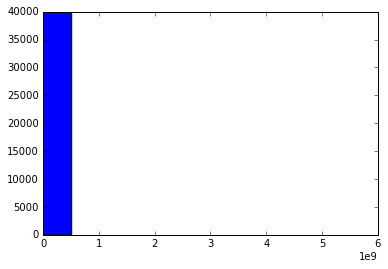

In [ ]:
plt.hist(sim.flatten())


In [ ]:
from sklearn.decomposition import PCA
fact=PCA(n_components=.999999999)
sim_txf=fact.fit_transform(sim)
((sim-fact.components_[sim_txf.argmax(axis=1)])**2).sum()

2.9671613001081676e+19

### len(orgs), len(set(x[0] for x in orgs)),len(set(x[1] for x in orgs))

In [ ]:
pprint(activities.find_one())

{u'@default-currency': u'USD',
 u'@generated-datetime': u'2016-06-25T22:49:09',
 u'@hierarchy': u'1',
 u'@last-updated-datetime': u'2016-04-29T10:55:00',
 u'@w210-key': u'ocha_fts-central_african_republic_2015',
 u'@xml:lang': u'en',
 u'_id': ObjectId('5785cc43ea05914e24a7f915'),
 u'activity-date': [{u'@iso-date': u'2015-01-01', u'@type': u'1'},
                    {u'@iso-date': u'2015-12-31', u'@type': u'3'}],
 u'activity-status': {u'@code': u'2'},
 u'budget': [{u'@type': u'1',
              u'period-end': {u'@iso-date': u'2015-12-31'},
              u'period-start': {u'@iso-date': u'2015-01-01'},
              u'value': {u'#text': u'0', u'@value-date': u'2015-01-01'}},
             {u'@type': u'2',
              u'period-end': {u'@iso-date': u'2015-12-31'},
              u'period-start': {u'@iso-date': u'2015-01-01'},
              u'value': {u'#text': u'0', u'@value-date': u'2015-01-01'}}],
 u'description': {u'@type': u'2', u'narrative': u'n/a'},
 u'fts:appeal-title': {u'#text': u'

## Perform Join

In [ ]:
joined_activities = activities.aggregate([{
    '$lookup': {
        'from': 'metadata',
        'localField': '@w210-filename',
        'foreignField': '@w210-filename',
        'as': 'metadata'
    }
}])

In [ ]:
next(joined_activities)

{u'@default-currency': u'USD',
 u'@generated-datetime': u'2016-06-25T22:49:09',
 u'@hierarchy': u'1',
 u'@last-updated-datetime': u'2016-04-29T10:55:00',
 u'@w210-key': u'ocha_fts-central_african_republic_2015',
 u'@xml:lang': u'en',
 u'_id': ObjectId('5785cc43ea05914e24a7f915'),
 u'activity-date': [{u'@iso-date': u'2015-01-01', u'@type': u'1'},
  {u'@iso-date': u'2015-12-31', u'@type': u'3'}],
 u'activity-status': {u'@code': u'2'},
 u'budget': [{u'@type': u'1',
   u'period-end': {u'@iso-date': u'2015-12-31'},
   u'period-start': {u'@iso-date': u'2015-01-01'},
   u'value': {u'#text': u'0', u'@value-date': u'2015-01-01'}},
  {u'@type': u'2',
   u'period-end': {u'@iso-date': u'2015-12-31'},
   u'period-start': {u'@iso-date': u'2015-01-01'},
   u'value': {u'#text': u'0', u'@value-date': u'2015-01-01'}}],
 u'description': {u'@type': u'2', u'narrative': u'n/a'},
 u'fts:appeal-title': {u'#text': u'Central African Republic 2015',
  u'@xmlns:fts': u'nothing'},
 u'fts:appeal-type': {u'#text': u

## Extract Text

Text will be extracted as all fields on the `iati-activity` element as will as all fields on the parent `iati-activities` element.

In [ ]:
def extract_text(json_object):
    if json_object is None:
        return ''

    text = []

    object_type = type(json_object)

    # Recursively extract the text based on the data structure until we are at
    # the "no data structure here" text leaf node.

    if object_type is dict:
        text = [extract_text(value) for value in json_object.itervalues()]
    elif object_type is list:
        text = [extract_text(value) for value in json_object]
    elif object_type is str or object_type is unicode:
        text = [re.sub(r'\s+', ' ', unicode(json_object)).strip()]
    elif object_type is bson.objectid.ObjectId:
        text = []
    else:
        print(object_type)

    return ' '.join([item for item in text if len(item) > 0])

In [ ]:
def is_valid_ref_format(ref):
    if ref.find('-') == -1:
        return False

    if ref.find(' ') != -1:
        return False

    return True

In [ ]:
%%time
parse_failures = []
activities_count = activities.count()

print(datetime.now(), 'Started processing')

with io.open('iati_text.txt', 'w', encoding='utf-8') as f:
    for num, activity in enumerate(joined_activities):
        if num % 25000 == 0:
            print(datetime.now(), 'Processed', num, 'of', activities_count)

        try:
            row_id = activity['reporting-org']['@ref']

            if is_valid_ref_format(row_id):
                f.write(row_id + '\t' + extract_text(activity) + '\n')
        except Exception as e:
            parse_failures.append((activity, e))

print(datetime.now(), 'Finished processing')

2016-08-09 20:02:48.949379 Started processing
2016-08-09 20:02:48.949794 Processed 0 of 579320
2016-08-09 20:03:14.037412 Processed 25000 of 579320
2016-08-09 20:03:36.605837 Processed 50000 of 579320
2016-08-09 20:03:56.505320 Processed 75000 of 579320
2016-08-09 20:04:20.176770 Processed 100000 of 579320
2016-08-09 20:04:46.212902 Processed 125000 of 579320
2016-08-09 20:05:10.313154 Processed 150000 of 579320
2016-08-09 20:05:32.623133 Processed 175000 of 579320
2016-08-09 20:05:54.823963 Processed 200000 of 579320
2016-08-09 20:06:13.951098 Processed 225000 of 579320
2016-08-09 20:06:36.129481 Processed 250000 of 579320
2016-08-09 20:06:58.823961 Processed 275000 of 579320
2016-08-09 20:07:15.913969 Processed 300000 of 579320
2016-08-09 20:07:41.354056 Processed 325000 of 579320
2016-08-09 20:08:01.713421 Processed 350000 of 579320
2016-08-09 20:08:25.723077 Processed 375000 of 579320
2016-08-09 20:08:47.002416 Processed 400000 of 579320
2016-08-09 20:09:07.004695 Processed 425000 

Also want to check for failures.

In [ ]:
len(parse_failures)

543

# Upload to S3

In [ ]:
if os.path.isfile('iati_text.txt'):
    !rm -f iati_text.txt.gz
    !gzip iati_text.txt

!aws s3 cp iati_text.txt.gz s3://mdang.w210/ --acl public-read

upload: ./iati_text.txt.gz to s3://mdang.w210/iati_text.txt.gz
